# 1. Read Data

In [35]:
!pip install parse

In [36]:
import pandas as pd
import numpy as np
import random
import math
from parse import *
import os
import sklearn
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

# read files
files = [  f for f in os.listdir("./results/") if f.endswith('_dataByMinute.xlsx')]
# read data
tags_order = []
all_points_array = []
dict_df = {}
for f in files:
    df = pd.read_excel(open('results/'+f,'rb'))
    parsed = parse("{}_{}_{}",f)
    #print(parsed)
    my_date = '2022-'+parsed[1][:2]+'-'+parsed[1][2:]
    #print(my_date)
    points = []
    for i in range(1, len(df['hour'])):
        point = [df['x值'][i],df['y值'][i]]
        points.append(point)
    points_array = np.array(points)
    tags_order.append(parsed[0])
    all_points_array.append(points_array)
    dict_df[parsed[0]+"_"+my_date] = df

In [37]:
print(len(all_points_array))

36


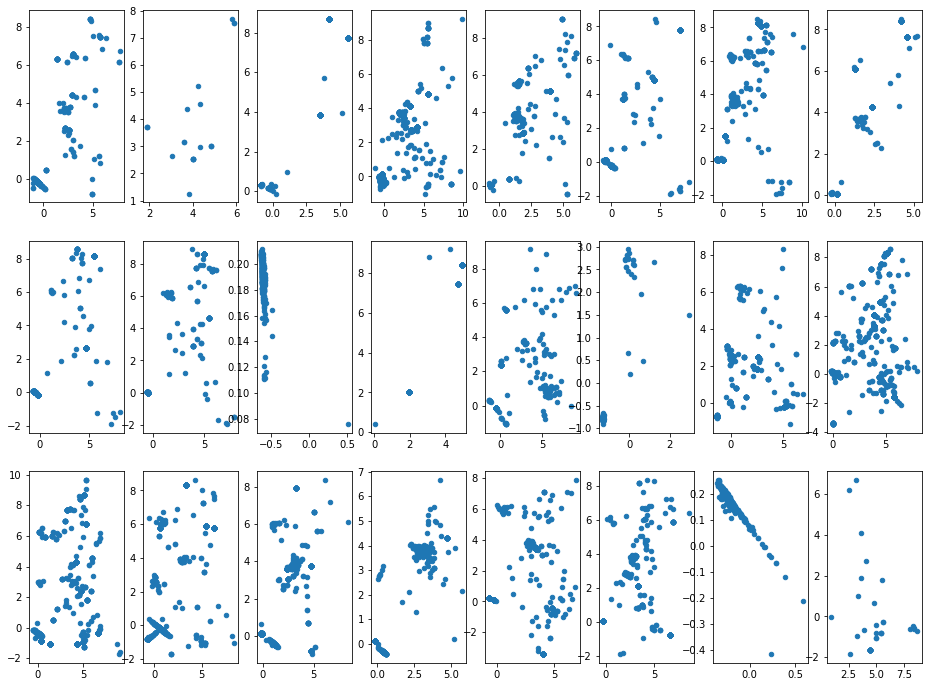

In [38]:
fig = plt.figure(figsize = (16, 12))

for i in range(1,25):
    ax = plt.subplot(3,8,i)
    #ax.text(0.5, 0.5, str((3,8,i)), fontsize=18, ha='center')
    #plt.title(my_date)
    ax.scatter(all_points_array[i-1][:,0],all_points_array[i-1][:,1],s=20)


In [39]:
# for i in range(len(all_points_array)):
#     ps = all_points_array[i]
#     fig = plt.figure(figsize = (10, 15),dpi=300)
#     plt.title(my_date)
#     plt.scatter(ps[:,0],ps[:,1],s=20)
#     plt.savefig('./figures/'+tags_order[i] +"_"+ my_date + '.png')
#     plt.close(fig)

# 2. Grid Creator

In [376]:
df = dict_df["tag1_2022-03-27"]

In [377]:
xs = []
ys = []
ts = []
for i in range(1, len(df['hour'])):
    ts.append(df['time'][i])
    xs.append(df['x值'][i])
    ys.append(df['y值'][i])
c={ "time":ts,"x":xs,'y':ys} 
data= pd.DataFrame(c)
max_x = 12
min_x = -2.5
max_y = 10
min_y = -4.5
unit = 0.5  #网格单元长宽m
column_num = int((max_x-min_x)//unit)
row_num = int((max_y-min_y)//unit)

In [378]:
def generalID(x,y,column_num,row_num):
    # 若在范围外的点，返回-1
    if x <= min_x or x >= max_x or y <= min_y or y >= max_y:
        return -1
    # 把x范围根据列数等分切割
    column = (max_x - min_x)/column_num
    # 把y范围根据行数数等分切割
    row = (max_y - min_y)/row_num
    # 二维矩阵坐标索引转换为一维ID，即： （列坐标区域（向下取整）+ 1） + （行坐标区域 * 列数）
    return int((x-min_x)//column)+ 1 + int((y-min_y)//row) * column_num
data['label'] = data.apply(lambda x: generalID(x['x'], x['y'],column_num,row_num), axis = 1)

In [379]:
groups = data['label'].value_counts()
# groups = data.groupby('label') 
# groups.size() # count the number of each grid
print(groups)
# re-organize the grid
grids = np.zeros([row_num,column_num])
for i in groups.index:
    r = (i-1)//column_num  # e.g. (6 - 1) // 12 = 0; (13-1) // 12 = 1; (12-1) // 12 = 0
    c = i - column_num * r - 1 # e.g. 6 - 0 * 12 - 1= 6; 13 - 1 * 12 -1= 0; 12 - 0 * 12 - 1 = 11
    grids[r,c] = math.sqrt(groups[i])/math.sqrt(max(groups))  # Do a sqrt to make the heatmap clearer !!!
print(grids)

209    137
182    122
251     98
507     81
419     60
      ... 
595      1
280      1
303      1
586      1
363      1
Name: label, Length: 76, dtype: int64
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0. 

# 3. "heatmap"

In [380]:
!pip install seaborn

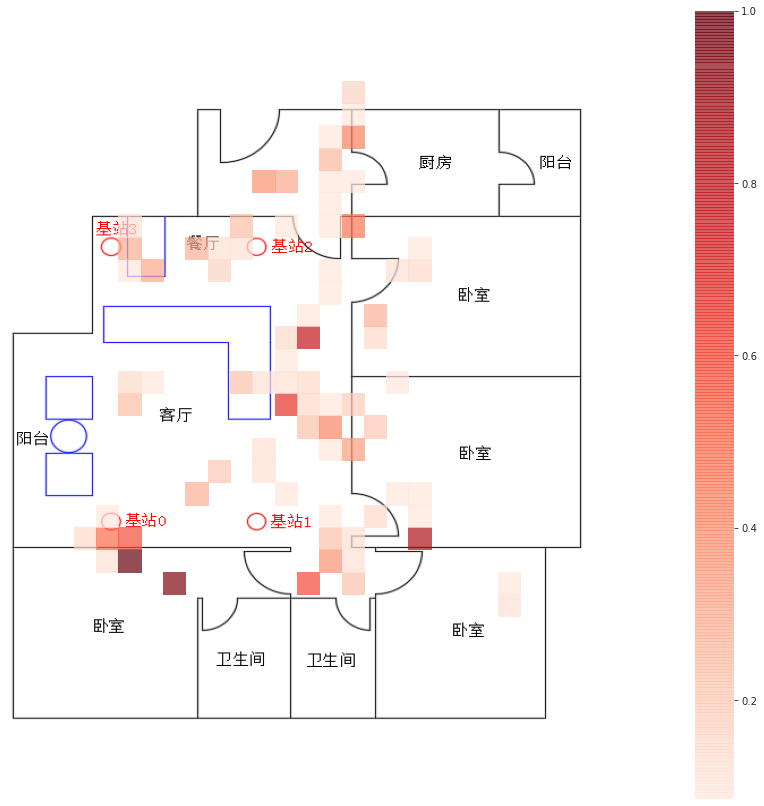

In [381]:
import matplotlib.image as mpimg 
map_img = mpimg.imread('floorplan01.png') 
import seaborn as sns
#specify size of heatmap
fig, ax = plt.subplots(figsize=(column_num*0.5,row_num*0.5))
with sns.axes_style("white"):
    ax = sns.heatmap(grids, cmap='Reds',linewidths=.0,alpha=.7,xticklabels =False,square = True,yticklabels =False,mask=(grids==0.),center=0.5)
ax.invert_yaxis()
plt.imshow(map_img,zorder = 0, extent=[-0/unit,13/unit,-0/unit,14/unit])
#plt.show()
fig.savefig("figures/tag1_0327_dataByMinute_spatial.png",dpi=300)

# 4. slice by time

In [402]:
from collections import defaultdict
# choose zones of labels
dict_zones = defaultdict(list)
def select(label,zone_index,used_labels):
    if (label not in groups.index) or (label in used_labels) or groups[label] <=1 or label <= 0 or label > row_num*column_num :
        return False
    dict_zones[zone_index].append(label)
    used_labels.append(label)
    select(label-column_num,zone_index,used_labels)
    select(label+column_num,zone_index,used_labels)
    if label%column_num != 0:
        select(label+1,zone_index,used_labels)
    if label%column_num != 1:
        select(label-1,zone_index,used_labels)
    return True


In [403]:
zone_index = 1
used_labels = []
for label in groups.index:
    if label in used_labels:
        continue
    else:
        select(label,zone_index,used_labels)
        zone_index += 1
print(dict_zones)

defaultdict(<class 'list'>, {1: [209, 238, 237, 208, 236], 2: [182], 3: [251], 4: [507, 506], 5: [419, 448, 449, 420, 391, 392, 447, 446], 6: [188], 7: [654], 8: [770], 9: [708, 709], 10: [218, 247, 248, 219, 190], 11: [364], 12: [587], 13: [615, 644], 14: [539, 510], 15: [618, 619, 590, 620, 649], 16: [299], 17: [740], 18: [412, 441], 19: [329], 20: [394], 21: [422], 22: [828], 23: [278], 24: [599, 598], 25: [168], 26: [360, 331]})


In [404]:
import datetime
from datetime import timedelta
# slice by time
def sliceByTime(time_list):
    max_interval = 1
    times_in_zone = []
    epsilon = timedelta(minutes=10)
    temp_count = 1
    start_time = time_list[0]
    end_time = time_list[0]
    for i in range(1,len(time_list)):
        t1 = time_list[i-1]
        t2 = time_list[i]
        time_delta = timedelta(hours=t2.hour,minutes=t2.minute) - timedelta(hours=t1.hour,minutes=t1.minute) 
        if time_delta >= epsilon:
            max_interval = max(temp_count,max_interval)
            temp_count = 1
            end_time = t1
            times_in_zone.append([start_time,end_time])
            start_time = t2
        else:
            temp_count += 1
    max_interval = max(max_interval,temp_count)
    end_time = time_list[-1]
    times_in_zone.append([start_time,end_time])
    return max_interval,times_in_zone

In [405]:
# get the data of corresponding zone
result = {}
details = {}
for zone in dict_zones:
    labels = dict_zones[zone]
    data_zone = data.loc[data['label'].isin(labels)]
    # print(data_zone)
    time_list = data_zone['time'].tolist()
    result[zone],details[zone] = sliceByTime(time_list)

print(result)
#print(details)

{1: 220, 2: 122, 3: 95, 4: 81, 5: 61, 6: 47, 7: 29, 8: 25, 9: 19, 10: 25, 11: 16, 12: 13, 13: 14, 14: 11, 15: 9, 16: 11, 17: 9, 18: 11, 19: 6, 20: 6, 21: 5, 22: 4, 23: 3, 24: 5, 25: 2, 26: 3}


# 5. heatmap by time

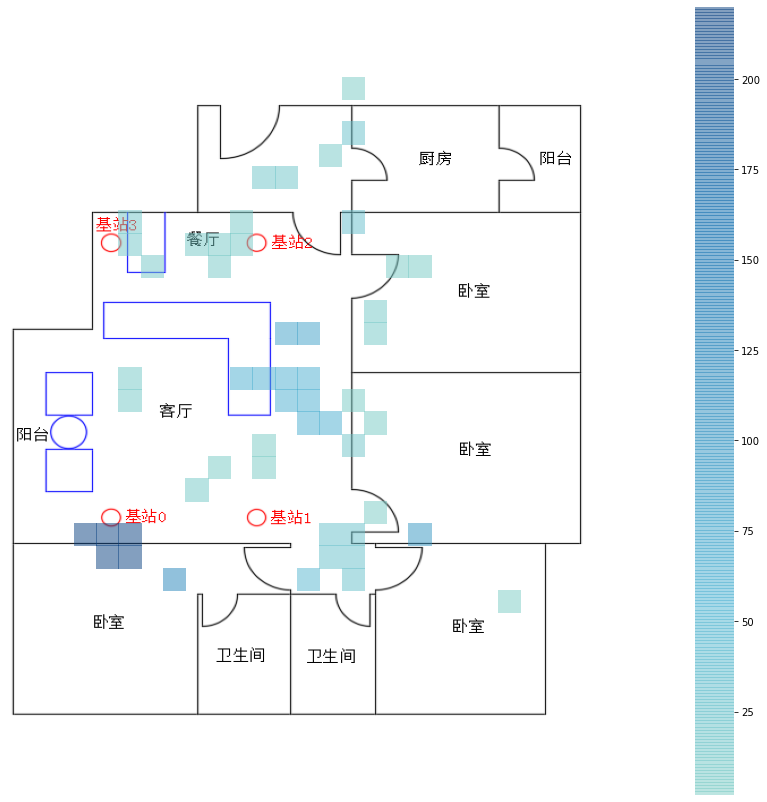

In [406]:
import matplotlib.image as mpimg 
map_img = mpimg.imread('floorplan01.png') 

# re-organize the grid
new_grids = np.zeros([row_num,column_num])
for zone in result:
    for label in dict_zones[zone]:
        r = (label-1)//column_num  # e.g. (6 - 1) // 12 = 0; (13-1) // 12 = 1; (12-1) // 12 = 0
        c = label - column_num * r - 1 # e.g. 6 - 0 * 12 - 1= 6; 13 - 1 * 12 -1= 0; 12 - 0 * 12 - 1 = 11
        new_grids[r,c] = result[zone]  # Do a sqrt to make the map clearer !!!
#specify size of heatmap
fig, ax = plt.subplots(figsize=(column_num*0.5,row_num*0.5))
ax = sns.heatmap(new_grids, cmap='GnBu',linewidths=0,alpha=0.5,xticklabels =False,square = True,annot=False,yticklabels =False,mask=(new_grids==0.),center=0.5)
ax.invert_yaxis()
#plt.show()
plt.imshow(map_img,zorder = 0, extent=[-0/unit,13/unit,-0/unit,14/unit])
fig.savefig("figures/tag1_0327_dataByMinute_temporal.png",dpi=300)

{1: 215, 2: 122, 3: 95, 4: 81, 5: 58, 6: 47, 7: 29, 8: 25, 9: 23, 10: 19, 11: 24, 12: 16, 13: 13, 14: 12, 15: 11, 16: 9, 17: 11, 18: 9, 19: 8, 20: 8, 21: 7, 22: 7, 23: 6, 24: 6, 25: 5, 26: 4, 27: 4}


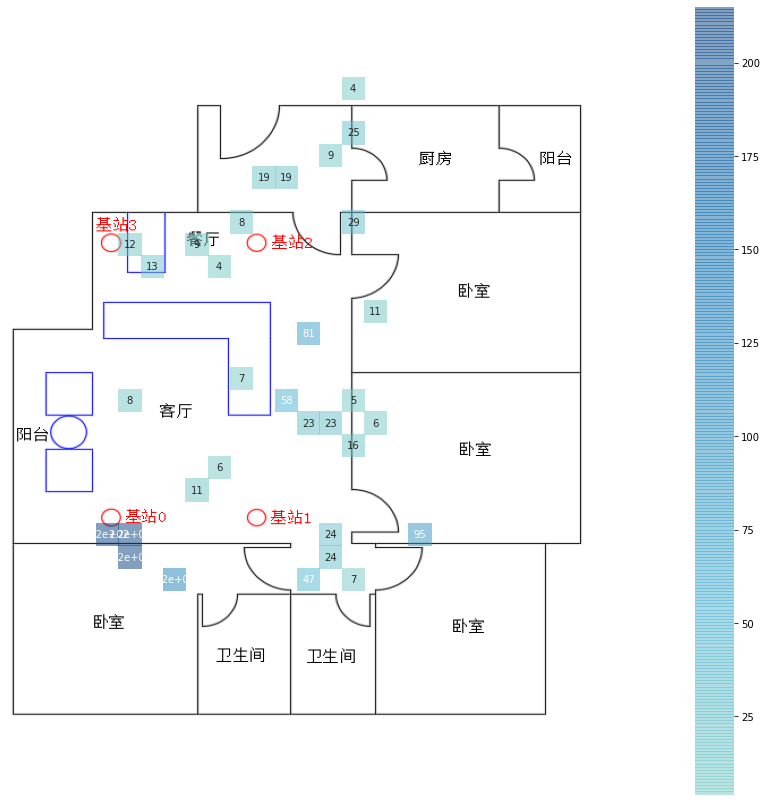

In [401]:
import matplotlib.image as mpimg 
map_img = mpimg.imread('floorplan01.png') 

fig, ax = plt.subplots(figsize=(column_num*0.5,row_num*0.5))
ax = sns.heatmap(new_grids, cmap='GnBu',linewidths=0,alpha=0.5,xticklabels =False,square = True,annot=True,yticklabels =False,mask=(new_grids==0.),center=0.5)
ax.invert_yaxis()
print(result)

#plt.show()
plt.imshow(map_img,zorder = 0, extent=[-0/unit,13/unit,-0/unit,14/unit])
fig.savefig("figures/tag1_0327_dataByMinute_temporal02.png",dpi=300)

# 6. Time line

In [388]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection
timeline = []
for zone in details:
    for t in details[zone]:
        # datetime.time to datetime.datetime
        date = str(datetime.datetime.strptime(my_date, '%Y-%m-%d').date())
        start = datetime.time(6,0,0)
        end = datetime.time(23,59,59)
        s = pd.to_datetime(date + " " + start.strftime("%H:%M:%S"))
        e = pd.to_datetime(date + " " + end.strftime("%H:%M:%S"))
        timeline.append((s, s, zone))
        timeline.append((e, e, zone))
        t0 = pd.to_datetime(date + " " + t[0].strftime("%H:%M:%S"))
        t1 = pd.to_datetime(date + " " + t[1].strftime("%H:%M:%S"))
        timeline.append((t0, t1, zone))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


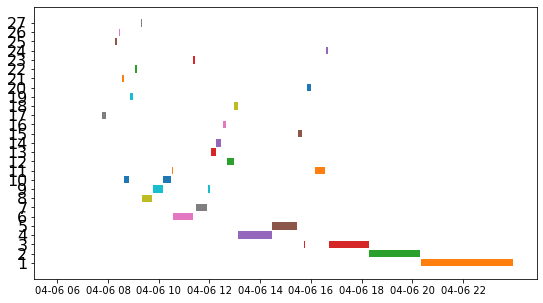

In [389]:
colormapping = {}
for zone in details:
    colormapping[zone] = "C"+str(zone)
verts = []
colors = []
for d in timeline:
    v =  [(mdates.date2num(d[0]), d[2]-.4),
          (mdates.date2num(d[0]), d[2]+.4),
          (mdates.date2num(d[1]), d[2]+.4),
          (mdates.date2num(d[1]), d[2]-.4),
          (mdates.date2num(d[0]), d[2]-.4)]
    verts.append(v)
    colors.append(colormapping[d[2]])
bars = PolyCollection(verts, facecolors=colors)
fig, ax = plt.subplots(figsize=(9,5))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.HourLocator(byhour=[6,8,10,12,14,16,18,20,22])
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_yticks(list(details.keys()))
ax.set_yticklabels(list(details.keys()),fontsize=16)
# ax.annotate('race interrupted', (61, 25),
#             xytext=(0.8, 0.9), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='top')
print(list(details.keys()))
plt.show()
fig.savefig("figures/tag1_0327_dataByMinute_time.png",dpi=300)